# Face recognition

<a target="_blank" href="https://colab.research.google.com/github/LuisAngelMendozaVelasco/luisangelmendozavelasco.github.io/blob/master/_portfolio/Deep_Learning_Specialization/portfolio-6.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png">Run in Google Colab</a>

**Objective**: Build a face recognition system using a pre-trained FaceNet model.

[FaceNet](https://arxiv.org/pdf/1503.03832.pdf) learns a neural network that encodes a face image into a vector of 128 numbers. By comparing two such vectors, we can then determine if two pictures are of the same person.

## Download FaceNet

In [1]:
%%bash

gdown -q https://drive.google.com/uc?id=1pbwUyttn5MWkc4kciW52Xlpf5esUjJUo -O ./keras_facenet.zip
unzip -q ./keras_facenet.zip
rm ./keras_facenet.zip

## Import libraries

In [2]:
from keras_facenet.inception_resnet_v1 import InceptionResNetV1
from keras import preprocessing
import matplotlib.pyplot as plt
import os
from PIL import Image
import numpy as np

2024-07-25 00:35:31.024792: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:10575] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-25 00:35:31.024833: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:479] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-25 00:35:31.026388: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1442] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-25 00:35:31.033719: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Visualize the dataset

This is a small [dataset](https://www.kaggle.com/datasets/dansbecker/5-celebrity-faces-dataset) containing photos of the following celebrities:

- Ben Afflek
- Elton John
- Jerry Seinfeld
- Madonna
- Mindy Kaling

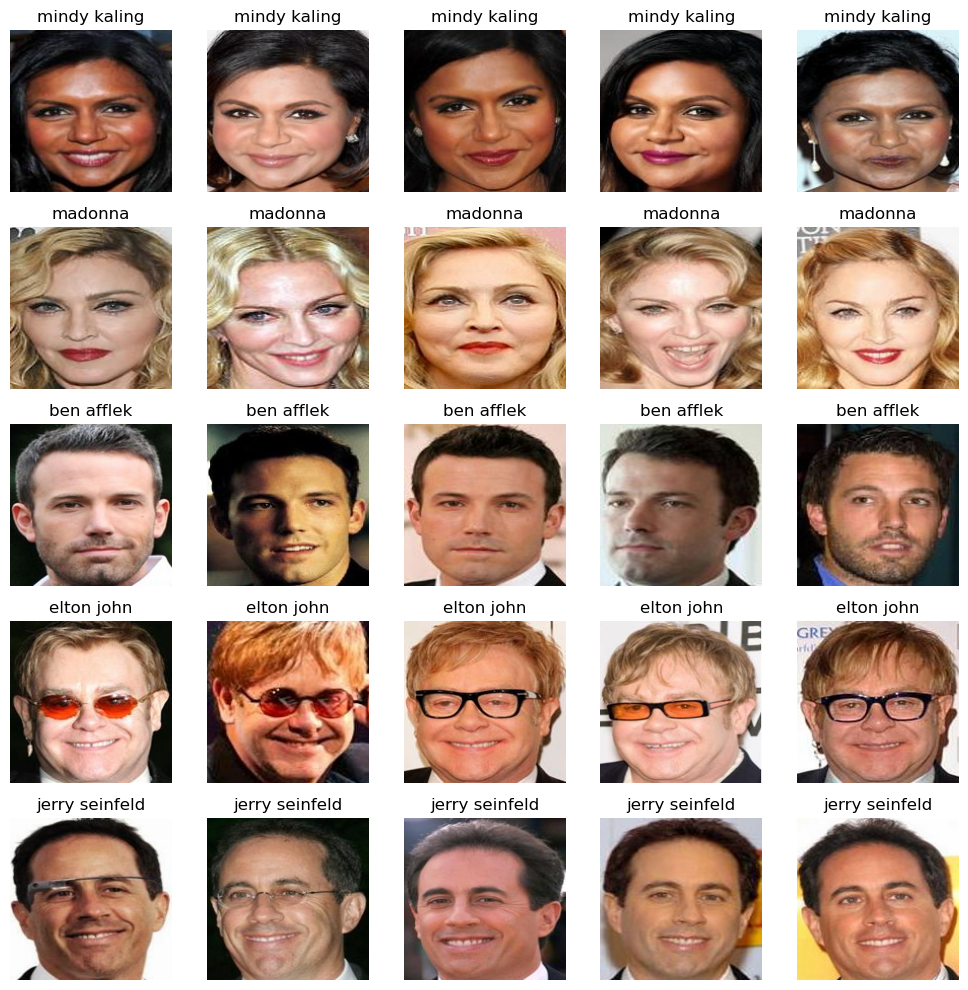

In [3]:
path = "./keras_facenet/Celebrity_Faces_Dataset/"

fig, axs = plt.subplots(5, 5, figsize=(10, 10))

for i, celebrity in enumerate(os.listdir(path)):
    for j, file in enumerate(os.listdir(path + celebrity)):
        image = Image.open(path + celebrity + "/" + file).resize((160, 160))
        axs[i, j].imshow(image)
        axs[i, j].axis("off")
        axs[i, j].set_title(celebrity.replace("_", " "))

plt.tight_layout()
plt.show()

## Load the pre-trained FaceNet model

The network architecture follows the Inception model from [Szegedy et al.](https://arxiv.org/pdf/1409.4842). 

This network uses 160x160 dimensional RGB images as its input. The output is matrix that encodes each input image into a 128-dimensional vector.

In [4]:
model = InceptionResNetV1(weights_path="./keras_facenet/weights.h5")

2024-07-25 00:35:35.025005: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1928] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 1812 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1650, pci bus id: 0000:01:00.0, compute capability: 7.5


## Evaluate the model

By computing the distance between two encodings and thresholding, we can determine if two pictures represent the same person. So, an encoding is a good one if:

- The encodings of two images of the same person are quite similar to each other.
- The encodings of two images of different persons are very different.

In [5]:
def image_to_encoding(image_path, model):
    image = preprocessing.image.load_img(image_path, target_size=(160, 160))
    image = np.around(np.array(image) / 255, decimals=12)
    image = np.expand_dims(image, axis=0)
    embedding = model.predict_on_batch(image)
    
    return embedding / np.linalg.norm(embedding, ord=2)

Build a database containing one encoding vector for each celebrity.

In [6]:
database = {}
database["mindy_kaling"] = image_to_encoding(path + "mindy_kaling/" + "mindy_kaling_1.jpg", model)
database["madonna"] = image_to_encoding(path + "madonna/" + "madonna_1.jpg", model)
database["ben_afflek"] = image_to_encoding(path + "ben_afflek/" + "ben_afflek_1.jpg", model)
database["elton_john"] = image_to_encoding(path + "elton_john/" + "elton_john_1.jpg", model)
database["jerry_seinfeld"] = image_to_encoding(path + "jerry_seinfeld/" + "jerry_seinfeld_1.jpg", model)

I0000 00:00:1721889340.455849   29409 service.cc:145] XLA service 0x7f8d1c003270 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1721889340.455882   29409 service.cc:153]   StreamExecutor device (0): NVIDIA GeForce GTX 1650, Compute Capability 7.5
2024-07-25 00:35:40.622342: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-07-25 00:35:41.825372: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8907
I0000 00:00:1721889344.807837   29409 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


In [7]:
def who_is_it(image_path, database, model):
    """
    Implements face recognition by finding who is the person on the image_path image.
    
    Arguments:
        image_path -- Path to an image
        database -- Database containing image encodings along with the name of the person on the image
        model -- Inception model instance in Keras
    
    Returns:
        minimum_distance -- The minimum distance between image_path encoding and the encodings from the database
        identity -- String, the name prediction for the person on image_path
    """

    ## Step 1: Compute the target "encoding" for the image.
    encoding = image_to_encoding(image_path, model)
    
    ## Step 2: Find the closest encoding.
    # Initialize "minimum_distance" to a large value.
    minimum_distance = 100
    
    # Loop over the database dictionary's names and encodings.
    for (name, database_encoding) in database.items():
        # Compute L2 distance between the target "encoding" and the current database_encoding from the database.
        distance = np.linalg.norm(encoding - database_encoding)

        # If this distance is less than the minimum_distance, then set minimum_distance to distance, and identity to name.
        if distance < minimum_distance:
            minimum_distance = distance
            identity = name
        
    return minimum_distance, identity

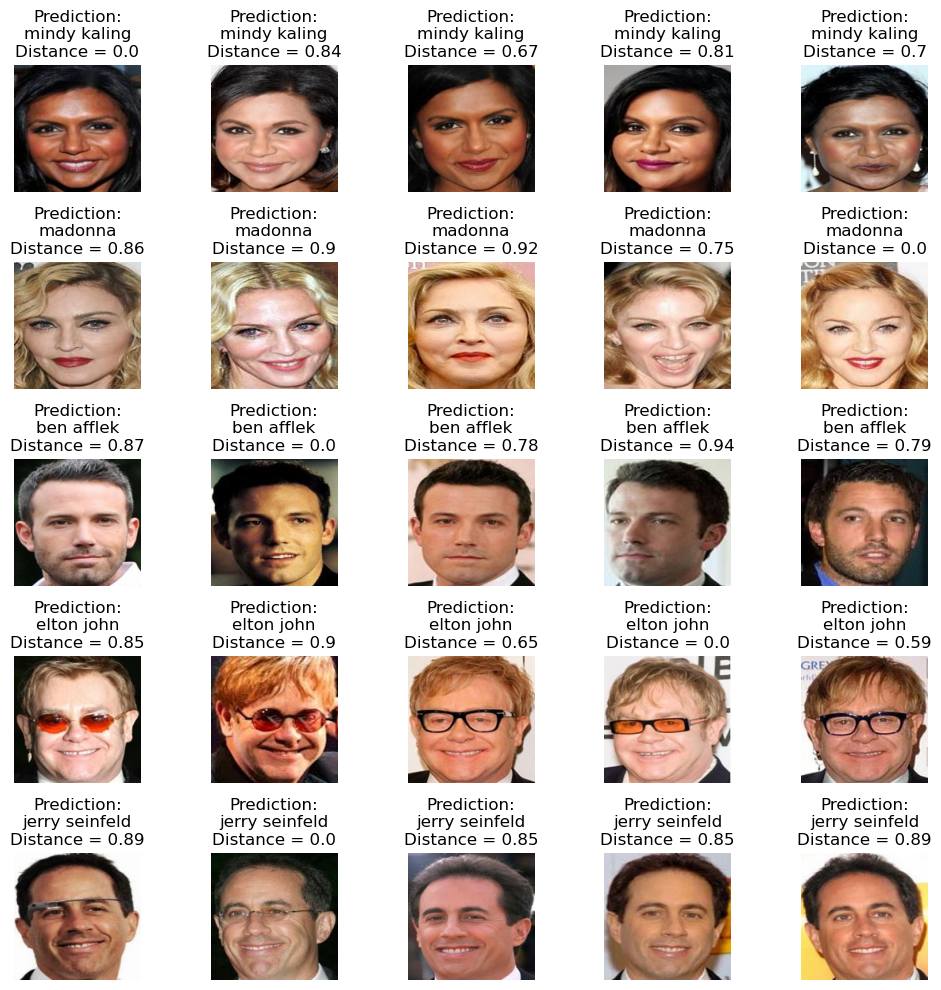

In [8]:
path = "./keras_facenet/Celebrity_Faces_Dataset/"

fig, axs = plt.subplots(5, 5, figsize=(10, 10))

for i, celebrity in enumerate(os.listdir(path)):
    for j, file in enumerate(os.listdir(path + celebrity)):
        image = Image.open(path + celebrity + "/" + file).resize((160, 160))
        minimum_distance, identity = who_is_it(path + celebrity + "/" + file, database, model)
        axs[i, j].imshow(image)
        axs[i, j].axis("off")
        axs[i, j].set_title("Prediction:\n" + identity.replace("_", " ") + "\nDistance = " + str(round(minimum_distance, 2)))

plt.tight_layout()
plt.show()

In [9]:
!rm -rf ./keras_facenet